In [2]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from fact.io import read_h5py
%matplotlib inline

exec(open('/home/msackel/Desktop/gammaClassification/programm/theta_cut/theta_cut.py').read())
exec(open('/home/msackel/Desktop/gammaClassification/programm/model_significance/model_significance.py').read())

xgbc = XGBClassifier(
            max_depth= 1,
            learning_rate= 0.5,
            n_estimators= 100,
            booster= 'gbtree', 
            gamma= 0.5,
            n_jobs= 15,
            reg_lambda= 0.1,
            subsample= 0.20,
            eval_metric= 'auc'
            )

Tree = RandomForestClassifier(
            max_depth=15, 
            max_features=7, 
            criterion='entropy', 
            n_estimators=100, 
            n_jobs=25
)


with open('/home/msackel/Desktop/gammaClassification/config/feature.yaml') as f:
        feature = yaml.load(f)


eval_data = pd.read_hdf('/home/msackel/Desktop/gammaClassification/data/raw_data/proton_precuts.hdf5')[feature]

print('---Theta**2 = 0.5')
train_Tree= theta_cut('/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5', 
                '/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5', 0.5) 

train_XGBC= theta_cut('/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5', 
                '/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5', 0.5) 

---Theta**2 = 0.5


In [3]:
xgbc.fit(train_XGBC.drop('label', axis=1), train_XGBC.label)
Tree.fit(train_Tree.drop('label', axis=1), train_Tree.label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=25, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

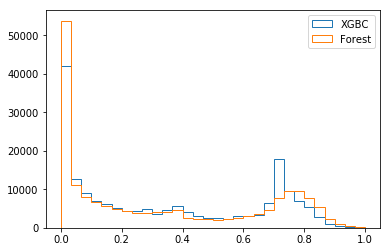

In [4]:
plt.hist(xgbc.predict_proba(eval_data[feature])[:,1], range=[0,1], bins=30, histtype='step', label='XGBC')
plt.hist(Tree.predict_proba(eval_data[feature])[:,1], range=[0,1], bins=30, histtype='step', label='Forest')
plt.legend(loc='best')

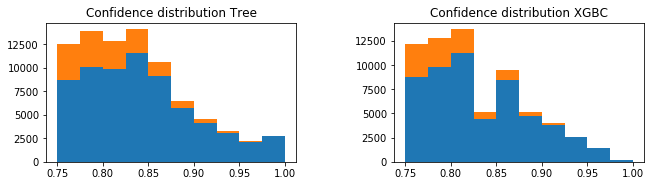

In [203]:
stack_data = pd.read_pickle('/home/msackel/Desktop/gammaClassification/data/dataSimu')
pred_tree = Tree.predict_proba(stack_data.drop('label', axis=1))[:,1]
pred_xgbc = xgbc.predict_proba(stack_data.drop('label', axis=1))[:,1]
fig = plt.figure()
ax1 = fig.add_subplot(221)
plt.title('Confidence distribution Tree')
plt.hist([pred_tree[stack_data['label']==1], pred_tree[stack_data['label']==0]], stacked=True, bins=10, range=[0.75,1])
#plt.ylim(0,10000)

ax2 = fig.add_subplot(222)
plt.title('Confidence distribution XGBC')
plt.hist([pred_xgbc[stack_data['label']==1], pred_xgbc[stack_data['label']==0]], stacked=True, bins=10, range=[0.75,1])
#plt.ylim(0,10000)
fig.tight_layout()
fig.set_size_inches(10,5)

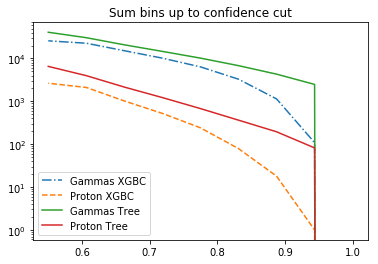

In [204]:
gammas_xgbc = np.histogram(pred_xgbc[stack_data['label']==1], bins=20, range=[0.55,1])[0][::-1]
proton_xgbc = np.histogram(pred_xgbc[stack_data['label']==0], bins=20, range=[0.55,1])[0][::-1]
Gumme_xgbc = np.array([])
Pumme_xgbc = np.array([])
for x in range(len(gammas)-1):
    Gumme_xgbc= np.append(Gumme_xgbc, sum(gammas_xgbc[:x]))
    Pumme_xgbc= np.append(Pumme_xgbc, sum(proton_xgbc[:x]))
plt.plot(np.linspace(1,0.55,len(Gumme_xgbc)), Gumme_xgbc, '-.', label='Gammas XGBC')
plt.plot(np.linspace(1,0.55,len(Pumme_xgbc)), Pumme_xgbc, '--', label='Proton XGBC')
gammas_Tree = np.histogram(pred_tree[stack_data['label']==1], bins=20, range=[0.55,1])[0][::-1]
proton_Tree = np.histogram(pred_tree[stack_data['label']==0], bins=20, range=[0.55,1])[0][::-1]
Gumme_Tree = np.array([])
Pumme_Tree = np.array([])
for x in range(len(gammas)-1):
    Gumme_Tree= np.append(Gumme_Tree, sum(gammas_Tree[:x]))
    Pumme_Tree= np.append(Pumme_Tree, sum(proton_Tree[:x]))
plt.plot(np.linspace(1,0.55,len(Gumme_Tree)), Gumme_Tree, label='Gammas Tree')
plt.plot(np.linspace(1,0.55,len(Pumme_Tree)), Pumme_Tree, label='Proton Tree')
plt.title('Sum bins up to confidence cut')
plt.yscale('log')
plt.legend()

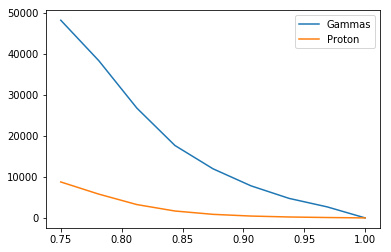

In [192]:
gammas = np.histogram(pred_tree[stack_data['label']==1], bins=10, range=[0.75,1])[0][::-1]
proton = np.histogram(pred_tree[stack_data['label']==0], bins=10, range=[0.75,1])[0][::-1]
Gumme = np.array([])
Pumme = np.array([])
for x in range(len(gammas)-1):
    Gumme= np.append(Gumme, sum(gammas[:x]))
    Pumme= np.append(Pumme, sum(proton[:x]))
plt.plot(np.linspace(1,0.75,len(Gumme)), Gumme, label='Gammas')
plt.plot(np.linspace(1,0.75,len(Pumme)), Pumme, label='Proton')
plt.legend()

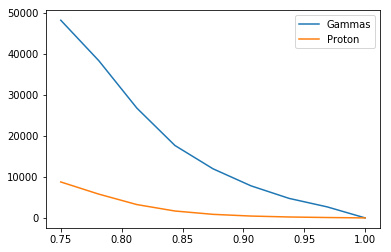

In [160]:
def compare_mc_model(mc_data, tree, xgbc, obsv_feat, conf_tree=0.5, conf_xgbc=0.5, scale=1):
    mc_keys = mc_data.keys()
    # make predictions on mc_data
    mc_data['pred_tree'] = Tree.predict_proba(mc_data[feature])[:,1]
    mc_data['pred_xgbc'] = xgbc.predict_proba(mc_data[feature])[:,1]
    
    pred_tree= mc_data.query('pred_tree <=' + str(conf_tree))[obsv_feat]
    pred_xgbc= mc_data.query('pred_xgbc <=' + str(conf_xgbc))[obsv_feat]
    pred_len = min([len(pred_tree),len(pred_xgbc)])

    print(len(pred_tree)/len(mc_data))
    max_feature = max([max(pred_tree), max(pred_xgbc)])
    min_feature = min([min(pred_tree), min(pred_xgbc)])
    # label data in dependence of confidence
    plt.hist(pred_tree[:pred_len], range=[min_feature, max_feature*scale], bins=30, histtype='step', label='Tree_pred')
    plt.hist(pred_xgbc[:pred_len], range=[min_feature, max_feature*scale], bins=30, histtype='step', label='XGBC_pred')
    plt.hist(mc_data[obsv_feat][:pred_len], range=[min_feature, max_feature*scale], bins=30, alpha=0.2, label='MC_simu')
    plt.xlabel(str(obsv_feat))
#    plt.yscale('log')
    plt.legend()
    plt.show()

0.8612186263349054


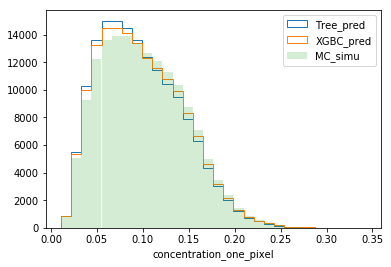

In [161]:
compare_mc_model(eval_data, Tree, xgbc, 'concentration_one_pixel',0.77, 0.77, )

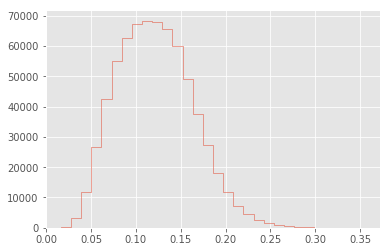

In [10]:
plt.hist(train_data.query('label ==1')['concentration_one_pixel'], bins=30, histtype='step')
None

In [9]:
eval_data.keys()

Index(['conc_core', 'concentration_one_pixel', 'concentration_two_pixel',
       'leakage', 'leakage2', 'size', 'width', 'num_islands',
       'num_pixel_in_shower', 'ph_charge_shower_max', 'ph_charge_shower_mean',
       'ph_charge_shower_variance', 'pred_tree', 'pred_xgbc'],
      dtype='object')

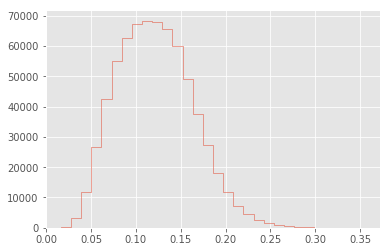

In [10]:
plt.hist(train_data.query('label ==1')['concentration_one_pixel'], bins=30, histtype='step')
None

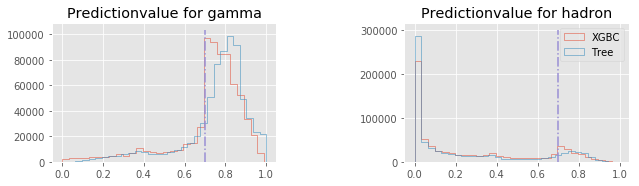

In [85]:
x = 0.70
gamma_xgbc = xgbc.predict_proba(train_Tree.query('label ==1')[feature])[:,1]
gamma_Tree = Tree.predict_proba(train_XGBC.query('label ==1')[feature])[:,1]
hadron_xgbc = xgbc.predict_proba(train_Tree.query('label ==0')[feature])[:,1]
hadron_Tree = Tree.predict_proba(train_XGBC.query('label ==0')[feature])[:,1]

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.set_title('Predictionvalue for gamma')
gamma_bin_xgbc = ax1.hist(gamma_xgbc, histtype='step', bins=30, label='XGBC')
gamma_bin_Tree = ax1.hist(gamma_Tree, histtype='step', bins=30, label='Tree')
ax1.plot((x, x),(0,max(np.append(gamma_bin_Tree[0],gamma_bin_xgbc[0]))*1.05), '-.')

ax2 = fig.add_subplot(222)
ax2.set_title('Predictionvalue for hadron')
hadron_bin_xgbc = ax2.hist(hadron_xgbc, histtype='step', bins=30, label='XGBC')
hadron_bin_Tree = ax2.hist(hadron_Tree, histtype='step', bins=30, label='Tree')
ax2.plot((x, x),(0,max(np.append(hadron_bin_Tree[0],hadron_bin_xgbc[0]))*1.05), '-.')
ax2.legend(loc='best')
fig.tight_layout()
fig.set_size_inches(10,5)
None